In [1]:
# display, transform, read, split ...
#기존 모델에 일정 에포크 이후 파인튜닝 (20번째부터)
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, Callback
from tensorflow.python.client import device_lib

#cutmix
from tensorflow.keras.utils import Sequence

# GPU 사용
os.environ['CUDA_HOME']='/home/j-j12c201/.conda/envs/fish'
os.environ['LD_LIBRARY_PATH']='/home/j-j12c201/.conda/envs/fish/lib'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# # CPU, GPU 사용 가능 여부 print
# print(device_lib.list_local_devices())

2025-03-21 03:38:02.068789: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 03:38:02.105706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 03:38:02.105727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 03:38:02.106667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 03:38:02.112869: I tensorflow/core/platform/cpu_feature_guar

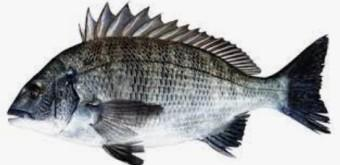

In [2]:
# 감성돔
data_full_dir = "fish_dataset/data_full"
img_gamsungdom = image.load_img(data_full_dir + "/감성돔/감성돔_0.jpg")
img_gamsungdom

### Split 데이터


In [3]:
data_split_dir = "fish_dataset/data_split"
splitfolders.ratio(data_full_dir, 
					output=data_split_dir, 
					seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

In [4]:
# split 후 파일 디렉토리 구조
# .
# ├── data_full
# │   ├── 갈치
# │   ├── 감성돔
# │   └── 갑오징어
# └── data_split
#     ├── test
#     │   ├── 갈치
#     │   ├── 감성돔
#     │   └── 갑오징어
#     ├── train
#     │   ├── 갈치
#     │   ├── 감성돔
#     │   └── 갑오징어
#     └── val
#         ├── 갈치
#         ├── 감성돔
#         └── 갑오징어

### CutMix

In [5]:
#랜덤 사각형 좌표 계산
def rand_box(height, width, lam):
    cut_rat=np.sqrt(1.-lam)
    cut_h=int(height*cut_rat)
    cut_w=int(width*cut_rat)

    #랜덤 중앙점
    cx=np.random.randint(width)
    cy=np.random.randint(height)

    #좌상단
    x1=np.clip(cx-cut_w//2, 0, width)
    y1=np.clip(cy-cut_h//2, 0, height)

    #우상단
    x2=np.clip(cx+cut_w//2, 0, width)
    y2=np.clip(cy+cut_h//2,0,height)

    return x1, y1, x2, y2

def cutmix(images, labels, alpha):
    batch_size=images.shape[0]
    height=images.shape[1]
    width=images.shape[2]

    #beta 분포에서 lam 샘플링
    lam=np.random.beta(alpha, alpha)

    #인덱스 셔플
    rand_idx=np.random.permutation(batch_size)


    x1, y1, x2, y2=rand_box(height, width, lam)

    #이미지 섞기
    images_modified = np.copy(images)
    for i in range(batch_size):
        images_modified[i, y1:y2, x1:x2, :] = images[rand_idx[i], y1:y2, x1:x2, :]
    
    #실제 영역 비율 정확히 다시 계산
    cut_area = (y2 - y1) * (x2 - x1)
    lam_actual = 1.0 - float(cut_area) / float(height * width)
    
    #라벨 섞기
    labels_modified = lam_actual * labels + (1.0 - lam_actual) * labels[rand_idx, :]
    
    return images_modified, labels_modified

class CutMixGenerator(Sequence):
    
    def __init__(self, base_generator, alpha, enable_cutmix=True):
        self.base_generator = base_generator
        self.alpha = alpha #Beta 분포 파라미터 (CutMix 세기 조절)
        self.enable_cutmix = enable_cutmix #True일 때만 CutMix 적용

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, idx):
        images, labels = self.base_generator[idx]
        
        if self.enable_cutmix:
            images, labels = cutmix(images, labels, alpha=self.alpha)
        
        return images, labels


In [6]:
#image 증강 
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,#정규화
    rotation_range=20,       # 회전, 이동, 전단 변형 등 이미지 증강
    width_shift_range=0.2,  
    height_shift_range=0.2, 
  #  shear_range=0.2,        
    zoom_range=0.1,          
    horizontal_flip=True,   
    fill_mode='nearest',      # 빈 공간 채우기
    brightness_range=[0.5, 1.5],#색, 밝기 변형
    channel_shift_range=50.0,
)
dataorigin=ImageDataGenerator(preprocessing_function=preprocess_input,)
# define classes name
class_names = [entry.name for entry in os.scandir(data_full_dir) if entry.is_dir()]
print(class_names)

['감성돔', '벵에돔', '참돔', '복섬', '문어', '돌돔', '주꾸미', '성대', '문절망둑', '갑오징어', '노래미', '독가시치', '전갱이', '망상어', '고등어', '무늬오징어', '볼락', '광어', '우럭', '붕장어', '갈치', '양태', '숭어', '삼치', '학공치', '농어']


### Combine generator

In [7]:
class CombinedGenerator(Sequence):
    def __init__(self, 
                 normal_generator,
                 augmentation_generator, 
                 cutmix_generator,
                 augmix_generator,
                 total_steps_per_epoch):
        self.normal_generator = normal_generator
        self.augmentation_generator=augmentation_generator
        self.cutmix_generator = cutmix_generator
        self.augmix_generator=augmix_generator
        self.total_steps = total_steps_per_epoch

        self.len_normal = len(self.normal_generator)
        self.len_cutmix = len(self.cutmix_generator)
        self.len_aug=len(self.augmentation_generator)
        self.len_augmix=len(self.augmix_generator)

        total_batch=self.len_normal+self.len_cutmix+self.len_aug+self.len_augmix

        self.ratio_normal=self.len_normal/total_batch
        self.ratio_cutmix=self.len_cutmix/total_batch
        self.ratio_aug=self.len_aug/total_batch
        self.ratio_augmix=self.len_augmix/total_batch

        self.steps_normal = int(self.total_steps * self.ratio_normal)
        self.steps_cutmix = int(self.total_steps * self.ratio_cutmix)
        self.steps_aug = int(self.total_steps * self.ratio_aug)
        self.steps_augmix = self.total_steps - (self.steps_normal + self.steps_cutmix + self.steps_aug)

    def __len__(self):
        return self.total_steps

    def __getitem__(self, idx):
    
        
        if idx < self.steps_normal:
            # 앞쪽 절반 인덱스: normal_generator의 배치 사용
            batch_idx = idx % self.len_normal
            images, labels = self.normal_generator[batch_idx]
        elif idx < self.steps_normal + self.steps_cutmix:
            batch_idx = (idx - self.steps_normal) % self.len_cutmix
            images, labels = self.cutmix_generator[batch_idx]
        elif idx < self.steps_normal + self.steps_cutmix + self.steps_aug:
            batch_idx = (idx - self.steps_normal - self.steps_cutmix) % self.len_aug
            images, labels=self.augmentation_generator[batch_idx]
        else:
            batch_idx = (idx - self.steps_normal - self.steps_cutmix - self.steps_aug) % self.len_augmix
            images, labels=self.augmix_generator[batch_idx]
        return images, labels

    def on_epoch_end(self):
      
        self.normal_generator.on_epoch_end()
        self.cutmix_generator.on_epoch_end()


In [8]:
# param
batch_size = 32
target_size = (224,224)
# training data
augmentation_generator = datagen.flow_from_directory( 
    directory=data_split_dir + "/train/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)
train_generator = dataorigin.flow_from_directory( 
    directory=data_split_dir + "/train/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)

# validation data
valid_generator = dataorigin.flow_from_directory( 
    directory=data_split_dir + "/val/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)

# test data
test_generator = dataorigin.flow_from_directory( 
    directory=data_split_dir + "/test/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="categorical", 
)

cutmix_train_generator=CutMixGenerator(
    base_generator=train_generator,
    alpha=1.0,
    enable_cutmix=True
)
augmix_train_generator=CutMixGenerator(
    base_generator=augmentation_generator,
    alpha=0.8,
    enable_cutmix=True
)

combine_generator=CombinedGenerator(train_generator,augmentation_generator, cutmix_train_generator,augmix_train_generator,316)


Found 2474 images belonging to 26 classes.
Found 2474 images belonging to 26 classes.
Found 300 images belonging to 26 classes.
Found 332 images belonging to 26 classes.


### ResNet50 Model


In [9]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False


# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x) 
#x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(26, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

2025-03-21 03:38:04.015001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:61:00.0, compute capability: 8.9


### CallBack

In [10]:

early_stopping = EarlyStopping(
    monitor="val_accuracy",  # 검증 정확도를 기준으로 학습 중단
    patience=3,  # 3 epoch 동안 정확도가 향상되지 않으면 중단
    verbose=1,
    mode="max", 
    min_delta=0.001
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)#손실 3 에포크 기준 감소하지 않으면 학습률*1/2



### Training

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])


In [12]:

#가벼운 증강
epochs_1=20
history_stage1 = model.fit(
    combine_generator,
    validation_data=valid_generator,
    epochs=epochs_1,
    callbacks=[lr_scheduler] 
)

for layer in model.layers[-30:]:
    layer.trainable = True
tf.keras.backend.set_value(model.optimizer.lr, 0.00006)

#파인튜닝                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
epochs_2=20
history_stage2 = model.fit(
    combine_generator,
    validation_data=valid_generator,
    epochs=epochs_1+epochs_2,
    initial_epoch=epochs_1,
    callbacks=[lr_scheduler, early_stopping] 
)

# #파인튜닝+강한 증강(alpha=0.6)_
# epochs_2=10
# history_stage2 = model.fit(
#     cutmix_train_generator_1,
#     validation_data=valid_generator,
#     epochs=epochs_1+epochs_2,
#     initial_epoch=epochs_1,  # 이전 학습 이어서
#     callbacks=[lr_scheduler, early_stopping] 
# )

# #(alpha=1.0)
# epochs_3=10
# history_stage2 = model.fit(
#     cutmix_train_generator_2,
#     validation_data=valid_generator,
#     epochs=epochs_1 + epochs_2+epochs_3,
#     initial_epoch=epochs_1+epochs_2,  # 이전 학습 이어서
#     callbacks=[lr_scheduler, early_stopping] 
# )

Epoch 1/20


2025-03-21 03:38:08.591463: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-21 03:38:08.662257: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-21 03:38:08.900660: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-21 03:38:09.836364: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa3b51a2aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-21 03:38:09.836386: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-21 03:38:09.841467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742528289.919767 1559012 device_compiler.h:186] Compi

316/316 [==============================] - 63s 186ms/step - loss: 2.8860 - accuracy: 0.1852 - val_loss: 1.6480 - val_accuracy: 0.5833 - lr: 3.0000e-04
Epoch 2/20
316/316 [==============================] - 57s 182ms/step - loss: 2.0610 - accuracy: 0.4506 - val_loss: 0.8666 - val_accuracy: 0.7833 - lr: 3.0000e-04
Epoch 3/20
316/316 [==============================] - 58s 183ms/step - loss: 1.6719 - accuracy: 0.5871 - val_loss: 0.5640 - val_accuracy: 0.8500 - lr: 3.0000e-04
Epoch 4/20
316/316 [==============================] - 58s 182ms/step - loss: 1.4924 - accuracy: 0.6471 - val_loss: 0.4763 - val_accuracy: 0.8800 - lr: 3.0000e-04
Epoch 5/20
316/316 [==============================] - 58s 184ms/step - loss: 1.3861 - accuracy: 0.6931 - val_loss: 0.4149 - val_accuracy: 0.8967 - lr: 3.0000e-04
Epoch 6/20
316/316 [==============================] - 57s 182ms/step - loss: 1.2806 - accuracy: 0.7276 - val_loss: 0.3435 - val_accuracy: 0.9033 - lr: 3.0000e-04
Epoch 7/20
316/316 [===================

### Loss & Accuracy Graph

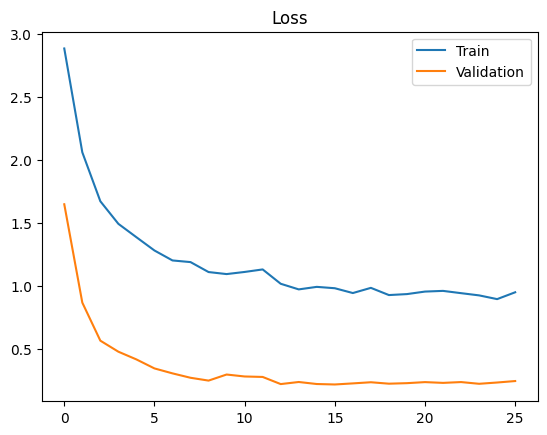

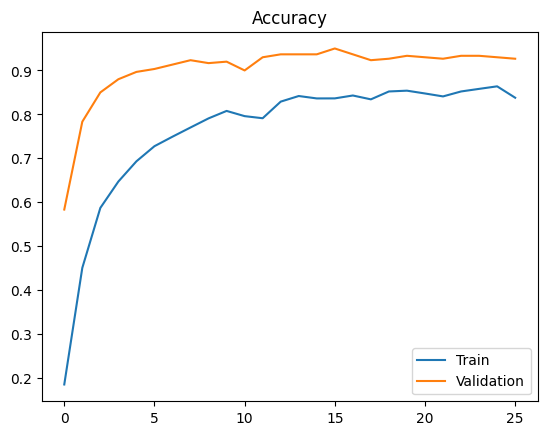

-0.08877760171890259


In [13]:
loss_train_curve = history_stage1.history["loss"]+history_stage2.history["loss"]
loss_val_curve = history_stage1.history["val_loss"]+history_stage2.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = history_stage1.history["accuracy"]+history_stage2.history["accuracy"]
acc_val_curve = history_stage1.history["val_accuracy"]+history_stage2.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()
gap=acc_train_curve[-1]-acc_val_curve[-1]
print(gap)

### 성능 평가

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

11/11 [==============================] - 1s 44ms/step - loss: 0.3445 - accuracy: 0.9217
The test loss is:  0.3445417881011963
The best accuracy is:  92.16867685317993


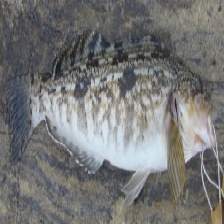

In [47]:
test_img = tf.keras.preprocessing.image.load_img('fish_dataset/data_split/test/노래미/노래미_110.png', 
                                            target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(test_img)
img_array = np.array([img_array]) 
test_img

In [48]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# transform classes number into classes name
print(class_names[class_id.item()])

1/1 [==============================] - 0s 21ms/step
[[4.99320973e-04 3.13760014e-04 4.60259733e-04 1.47278479e-03
  5.64295115e-05 1.09771645e-04 1.37117490e-06 6.36698853e-04
  1.28103967e-03 1.35456328e-04 9.80272114e-01 2.59683817e-03
  1.14691176e-03 3.50495597e-04 1.77055863e-05 1.11919513e-03
  1.10290217e-04 3.43324908e-04 3.50395497e-03 2.17570792e-04
  2.61384794e-05 4.95305518e-03 9.85143488e-05 8.79927829e-05
  3.04801015e-05 1.58585593e-04]]
[10]
노래미


### 전처리기 추가

In [ ]:
final_input=tf.keras.Input(shape=(None, None, 3), name='image_input')

x=tf.image.resize(final_input, (224, 224))
x=preprocess_input(x)

final_output=model(x)
 
model=tf.keras.Model(inputs=final_input, outputs=final_output)

### 모델 저장

In [ ]:
# directory
model.save('AI/model2/second_model')

# or h5 file
model.save('AI/model2/second_model_h5')

converter=tf.lite.TFLiteConverter.from_keras_model(model)

#quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model=converter.convert()


with open('quantization_model.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: AI/model2/second_model/assets


INFO:tensorflow:Assets written to: AI/model2/second_model/assets


INFO:tensorflow:Assets written to: AI/model2/second_model_h5/assets


INFO:tensorflow:Assets written to: AI/model2/second_model_h5/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ynn0ijo/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ynn0ijo/assets
2025-03-21 04:03:49.488546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-21 04:03:49.488575: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-21 04:03:49.488992: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1ynn0ijo
2025-03-21 04:03:49.513302: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-21 04:03:49.513320: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1ynn0ijo
2025-03-21 04:03:49.563926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-21 04:03:49.581319: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-21 04:03:50.125917: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [18]:
# model load
tf.keras.models.load_model('AI/model2/second_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          